In [2]:
#%config IPCompleter.use_jedi=False
%load_ext autoreload
%autoreload 2

In [3]:
import sys 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from pandas._libs.tslibs.timestamps import Timestamp
from pandas.core.frame import DataFrame
from pandas.core.series import Series
from matplotlib.axes._axes import Axes

sys.path.append('..')
from cyclingEfficiency import Clean, Eda, Visualize

## EDA parte 2
Ya se tiene la variable de eficiencia, ahora el objetivo es analizar como es el comportamiento de la misma con el resto de variables.

In [4]:
data = Clean(
    hr_max=190,
    kph_greater=2,
    cad_greater=40,
    hr_grater=0,
    slope_greater_than_equal=0,
    zone_grater_than_equal=1,
    before=False
).data

'''data = Eda(data, 11).data'''
def generate_w(
        slope: float, mass: float, 
        velocity_km_h: float, crr: float= 0.021
    ) -> float:
        gravity: float = 9.8
        if slope > 0:
            angle_radians: float = np.arctan(slope/100)
            f_g: float = mass * gravity * np.sin(angle_radians)
        else:
            f_g: float = 0
        f_r: float = mass * gravity * crr
        d: float = velocity_km_h * 1000 / (60 * 60)
        return d * (f_r + f_g)


bike_weight: float  = 11
data['w'] = data.apply(
    lambda x: generate_w(
        slope=x['slope'],
        mass=x['weight'] + bike_weight,
        velocity_km_h=x['kph']
    ),
    axis=1
)

data['w_hr'] = data['w'] / data['hr']
data['w_kg'] = data['w'] / data['weight']
data['w_kg_hr'] = data['w_kg'] / data['hr']
data['performance_indicator'] = data['w_kg'] / data['zones']

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612960 entries, 0 to 612959
Data columns (total 21 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   secs                   612960 non-null  int64         
 1   cad                    612960 non-null  float64       
 2   hr                     612960 non-null  float64       
 3   km                     612960 non-null  float64       
 4   kph                    612960 non-null  float64       
 5   watts                  612960 non-null  float64       
 6   alt                    612960 non-null  float64       
 7   lon                    612960 non-null  float64       
 8   lat                    612960 non-null  float64       
 9   slope                  612960 non-null  float64       
 10  temp                   612960 non-null  float64       
 11  datetime               612960 non-null  datetime64[ns]
 12  date                   612960 non-null  date

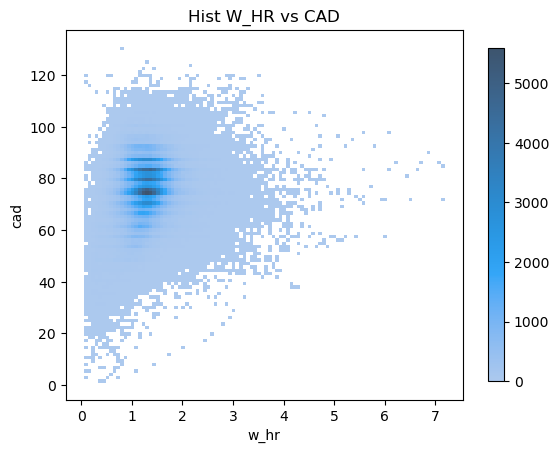

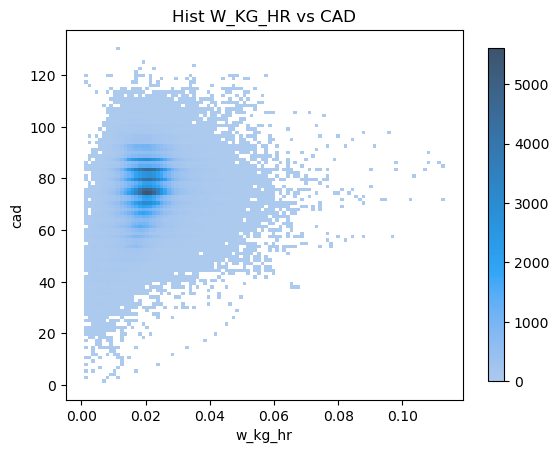

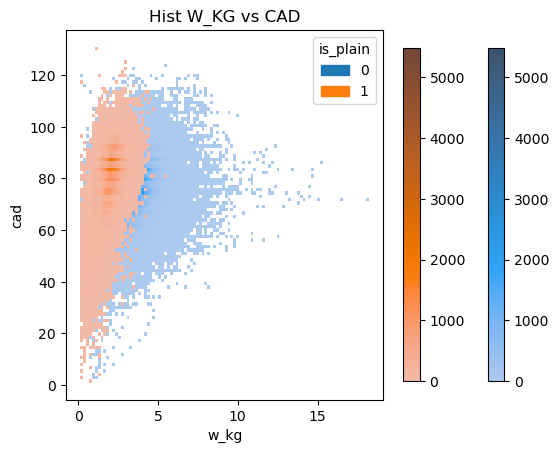

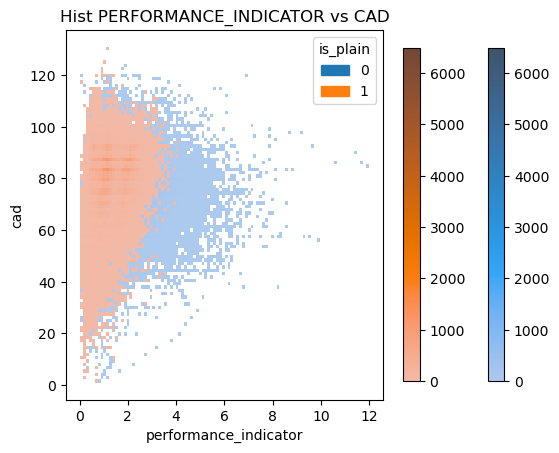

In [5]:
Visualize.hist_two_variables(
    data, 'w_hr', 'cad',
    bins=100
)

Visualize.hist_two_variables(
    data, 'w_kg_hr', 'cad',
    bins=100
)

Visualize.hist_two_variables(
    data, 'w_kg', 'cad',
    bins=100, hue='is_plain'
)

Visualize.hist_two_variables(
    data, 'performance_indicator', 'cad',
    bins=100, hue='is_plain'
)

En este punto se verá el cambio histórico del promedio de cada una de las variables importantes.

In [7]:
result = data.groupby(
    'date'
).agg({
    'w': np.mean,
    'w_hr': np.mean,
    'w_kg': np.mean,
    'w_kg_hr': np.mean,
    'performance_indicator': np.mean,
    'cad': np.mean,
    'secs': 'count'

}).reset_index()

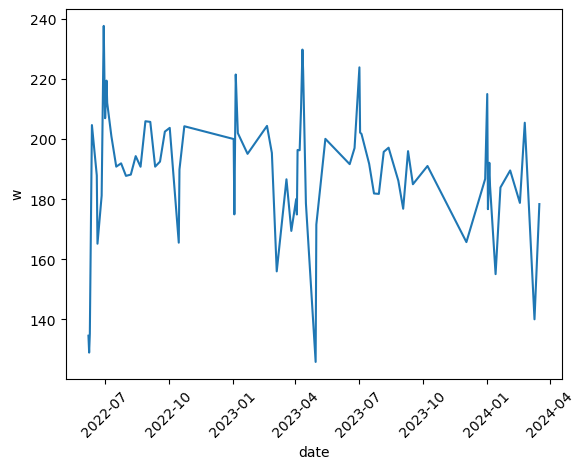

In [8]:
sns.lineplot(
    result.iloc[1:, :],
    x='date',
    y='w'
)
plt.xticks(rotation=45)
plt.show()



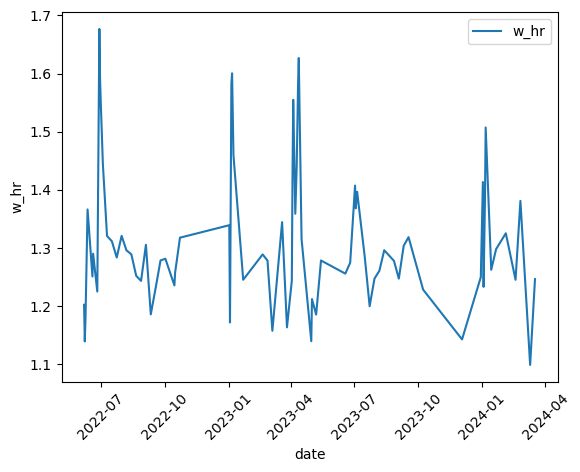

In [9]:
sns.lineplot(
    result.iloc[1:, :],
    x='date',
    y='w_hr',
    label='w_hr',
)

plt.xticks(rotation=45)
plt.show()


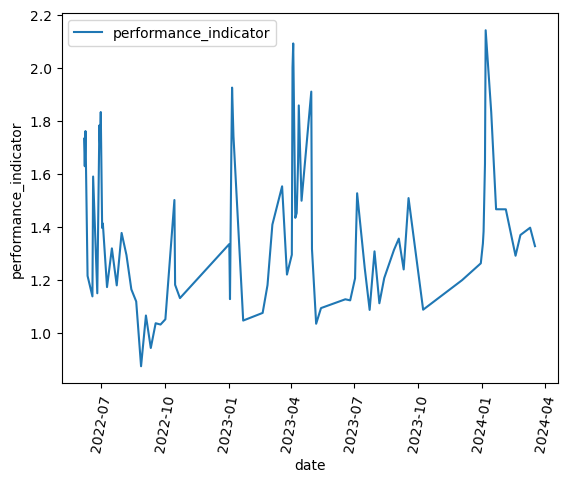

In [10]:
sns.lineplot(
    result.iloc[1:, :],
    x='date',
    y='performance_indicator',
    label='performance_indicator',
    
)

plt.xticks(rotation=80)
plt.show()


Ahora, con el fin de tener un análisis por intervalos de nivel de cadencia, y determinar rangos de cadencia que generan más eficiencia. Se creará una función que genera los intervalos según las indicaciones que se necesiten.

In [11]:
def generate_cad_zone(
        data: Series, cad_min: int, 
        cad_max: int, cad_step: int
    ) -> list[str]:
    cad_zones: list[int] = list(
        range(cad_min, cad_max + 1, cad_step)
    )

    cad_zones_name: list[str] = [
        '{}) {}-{}'.format(
            str(i+1).zfill(2), lower, lower + cad_step - 1
        ) 
        for i, lower in enumerate(cad_zones)
    ]

    size: int = len(cad_zones)
    result_cad_zones: list[int] = []

    for cad in data:
        flag: bool = True
        index: int = size - 1
        result: int = np.nan
        while flag and 0 <= index:
            if cad_zones[index] <= cad:
                if index == size - 1:
                    flag = False
                else:
                    result = cad_zones_name[index]
                    flag = False
            index -= 1  
        result_cad_zones.append(result)
    return result_cad_zones

data['cad_zone'] = generate_cad_zone(
    data['cad'], 55, 105, 5
)
data = data[~data['cad_zone'].isna()].reset_index(drop=True)

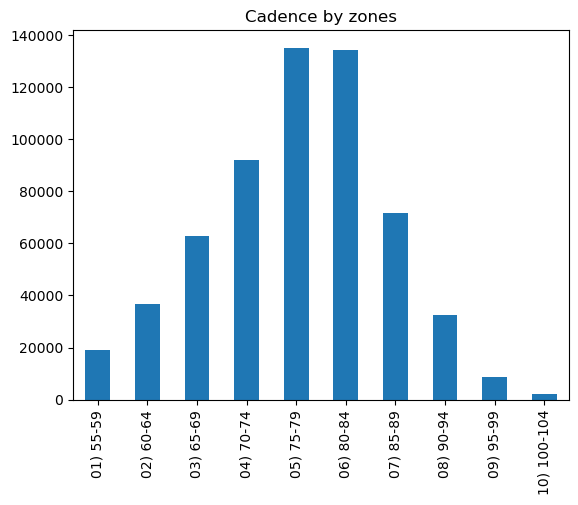

In [12]:
(
    data['cad_zone'].value_counts().sort_index()
).plot(kind='bar')
plt.title('Cadence by zones')
plt.show()

In [13]:
(
    data['cad_zone']
        .value_counts(normalize=True)
        .sort_index() * 100
)

01) 55-59       3.220448
02) 60-64       6.152999
03) 65-69      10.534440
04) 70-74      15.431039
05) 75-79      22.702200
06) 80-84      22.560099
07) 85-89      12.034225
08) 90-94       5.481463
09) 95-99       1.487187
10) 100-104     0.395900
Name: cad_zone, dtype: float64

In [14]:
data['cad_zone_num'] = data['cad_zone'].map(
    lambda x: int(x[:2])
)

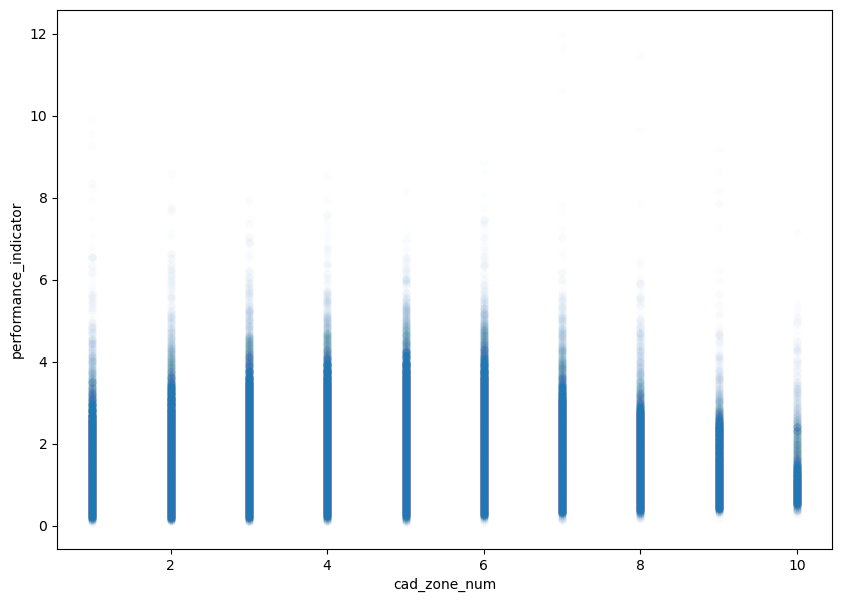

In [15]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data,
    x='cad_zone_num',
    y='performance_indicator',
    alpha=1/100
)
plt.show()

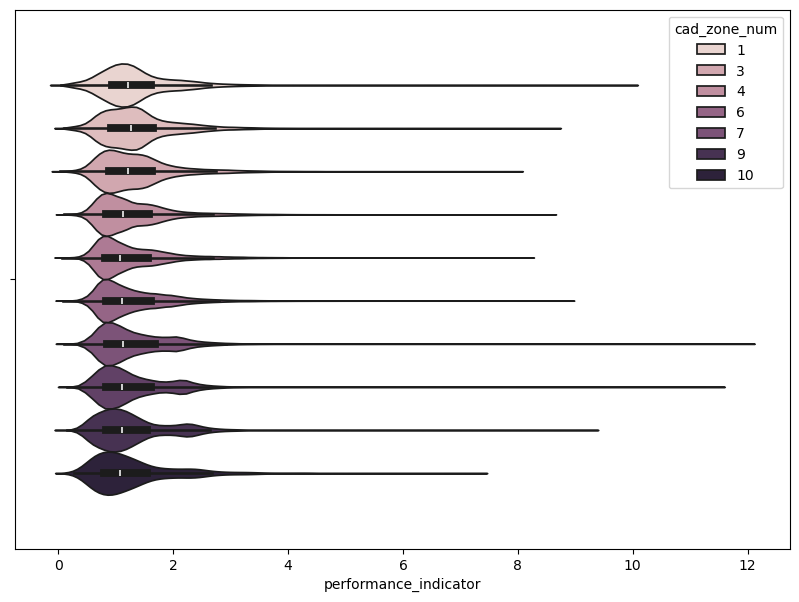

In [16]:
plt.figure(figsize=(10, 7))
sns.violinplot(
    data,
    x='performance_indicator',
    hue='cad_zone_num',
)
plt.show()

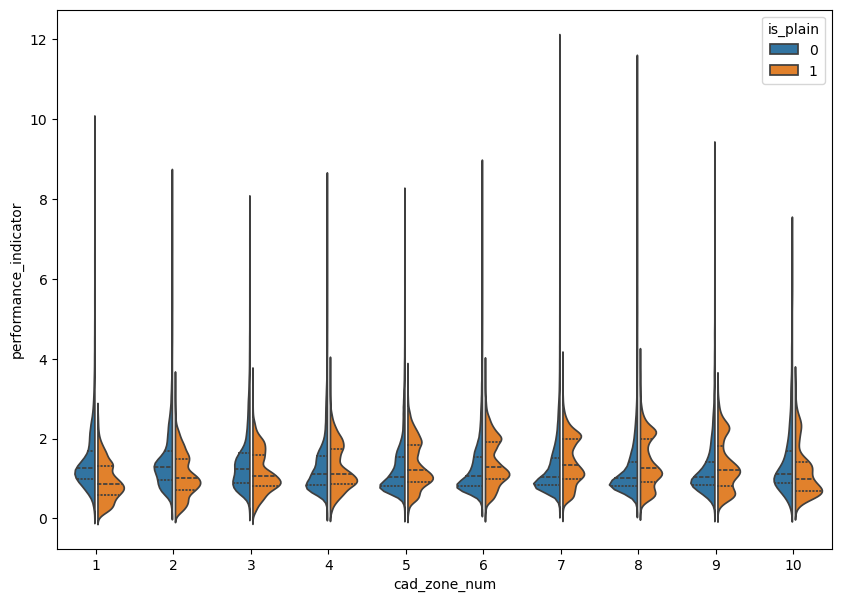

In [20]:
plt.figure(figsize=(10, 7))
sns.violinplot(
    data,
    y='performance_indicator',
    x='cad_zone_num',
    hue='is_plain',
    split=True,
    gap=.1, 
    inner="quart"
)
plt.show()

In [21]:
data.groupby(
    ['cad_zone_num', 'is_plain']
).agg(
    {'secs': 'count'}
)

secs
cad_zone_num is_plain        
1            0          16720
             1           2453
2            0          32129
             1           4503
3            0          54702
             1           8015
4            0          80764
             1          11105
5            0         116645
             1          18513
6            0         106345
             1          27967
7            0          48317
             1          23329
8            0          19096
             1          13538
9            0           4589
             1           4265
10           0           1239
             1           1118